In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import jax
jax.config.update('jax_platform_name', 'cpu')
from jax.tree_util import tree_map_with_path
import pickle as pkl

import os
from utils import *

def get_ckpt_paths(path):
    files = [f for f in os.listdir(path)]
    files = sorted(files, key = lambda f : int(f.split(".")[0]))

    return [(int(f.split(".")[0]),path + f) for f in files]

def load_ckpt(path):
    with open(path, "rb") as f:
        ckpt = pkl.load(f)

    return ckpt

def plot_stats(path, key, label, ax = None):
    x = []
    y = []
    for i,p in get_ckpt_paths(path):
        ckpt = load_ckpt(p)
        x.append(i)
        y.append(jnp.mean(ckpt[key]))
    if ax == None:
        plt.plot(x,y,label=label)
    else:
        ax.plot(x,y,label=label)


def plot_xhyperparams_yacc(paths, hyperparams, key, label, ax=None):
    x = []
    y = []
    for path,hparam in zip(paths,hyperparams):
        ckpt_paths = get_ckpt_paths(path)
        if len(get_ckpt_paths(path)) == 0:
            continue
        accs = []
        for _,p in ckpt_paths:
            ckpt = load_ckpt(p)
            accs.append(ckpt[key])
        accs = np.stack(accs,axis=0)
        max_acc = np.mean(np.max(accs,axis=0))

        x.append(hparam)
        y.append(np.max(max_acc))
    if ax == None:
        plt.plot(x,y,label=label)
    else:
        ax.plot(x,y,label=label)

def make_label(s):
    s = keystr(s)
    s = s.split("'][")[0].split("['")[1]
    return s

def plot_channel_norms(path, get_weights_fn, plot_fns, axs):
    timestamps = []
    stats = []

    assert len(plot_fns) == len(axs)

    cond_fn = lambda s,_ : "conv" in keystr(s).lower() and "kernel" in keystr(s).lower()
    def true_fn(_,x):
        return {"c_norm" : c_norm(x), "c_mean" : c_mean(x), "b_mean" : b_mean(x), "g_norm" : g_norm(x), "g_mean" : g_mean(x)}
    false_fn = lambda _,__ : None

    for i,p in get_ckpt_paths(path):
        ckpt = load_ckpt(p)
        timestamps.append(i)
        w = get_weights_fn(ckpt)

        stats.append(conditional_tree_map((w,),cond_fn,true_fn,false_fn))
    
    w = tree_map_with_path(lambda _,*x : jnp.stack(x,axis=1) if x is not None else None,*stats)

    for plot_fn,ax in zip(plot_fns,axs):
        jax.tree_util.tree_map_with_path(lambda s,x : ax.plot(timestamps,plot_fn(s,x),label=make_label(s)) if plot_fn(s,x) is not None else None, w)

       

2024-12-19 13:02:08.541236: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-19 13:02:08.549911: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-19 13:02:08.552507: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 13:02:08.938215: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [1]:
fig,axs = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(10,5)
mean_c_norm_fn = lambda s,x : jnp.mean(jnp.mean(x,axis=-1),axis=0) if "c_norm" in keystr(s).lower() else None
var_c_norm_fn = lambda s,x : jnp.mean(jnp.var(x,axis=-1),axis=0) if "c_norm" in keystr(s).lower() else None
plot_channel_norms("./exps_sgdm/wd0.005/states/",lambda ckpt : ckpt[0],[mean_c_norm_fn,var_c_norm_fn],axs)

axs[0].set_title(r'Sgdm with Weight Decay | Mean of channel norms')
axs[0].set_xlabel("training step")

axs[1].set_title(r'Sgdm with Weight Decay | Variance of channel norms')
axs[1].set_xlabel("training step")

_, labels = axs[1].get_legend_handles_labels()
fig.legend(labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5,-0.05), bbox_transform=fig.transFigure)
fig.tight_layout()

NameError: name 'plt' is not defined

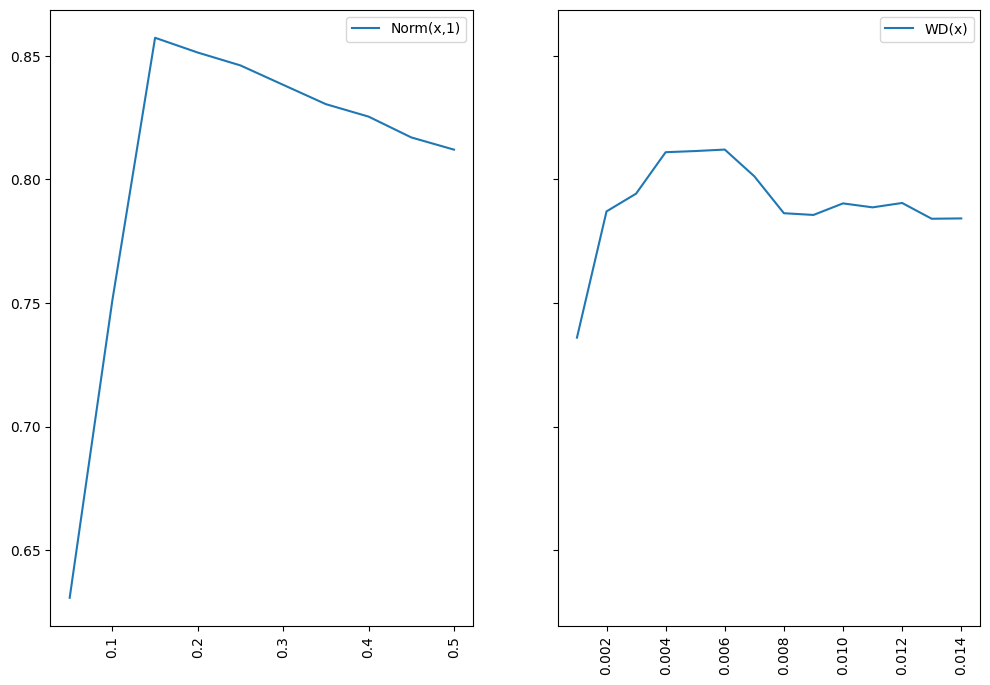

In [14]:
stats = "test_stats"

fig,axs = plt.subplots(ncols=2,sharey="all")
fig.set_size_inches((12,8))
to_plot = [("./exps_sgdm/norm",lambda p : p.endswith("1"),lambda x :  float(x.split("_")[0]),"acc","Norm(x,1)",axs[0]),
            ("./exps_sgdm/wd",lambda _ : True,lambda x :  float(x),"acc","WD(x)",axs[1]),]

for path,p_fn,to_x_fn,stat,name,ax in to_plot:
    hyperparams = []
    for p in os.listdir(path):
        if not os.path.exists(os.path.join(path,p,"test_stats")):
            continue
        if p_fn(p):
            hyperparams.append(p)
    hyperparams.sort(key=to_x_fn)
    plot_xhyperparams_yacc([os.path.join(path,p,stats)+"/" for p in hyperparams],[to_x_fn(p) for p in hyperparams],stat,name,ax)
    ax.legend()
    ax.tick_params(axis='x', labelrotation=90)


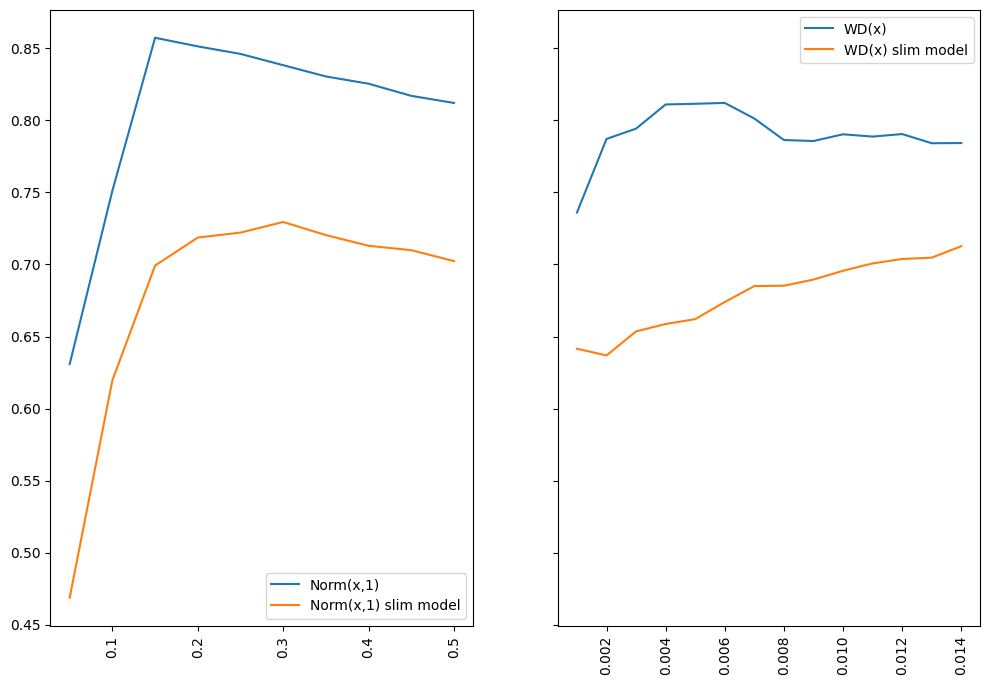

In [15]:
stats = "test_stats"

fig,axs = plt.subplots(ncols=2,sharey="all")
fig.set_size_inches((12,8))
to_plot = [("./exps_sgdm/norm",lambda p : p.endswith("1"),lambda x :  float(x.split("_")[0]),"acc","Norm(x,1)",axs[0]),
           ("./exps_sgdm/norm_slim",lambda p : p.endswith("1"),lambda x :  float(x.split("_")[0]),"acc","Norm(x,1) slim model",axs[0]),
            ("./exps_sgdm/wd",lambda _ : True,lambda x :  float(x),"acc","WD(x)",axs[1]),
            ("./exps_sgdm/wd_slim",lambda _ : True,lambda x :  float(x),"acc","WD(x) slim model",axs[1])]

for path,p_fn,to_x_fn,stat,name,ax in to_plot:
    hyperparams = []
    for p in os.listdir(path):
        if not os.path.exists(os.path.join(path,p,"test_stats")):
            continue
        if p_fn(p):
            hyperparams.append(p)
    hyperparams.sort(key=to_x_fn)
    plot_xhyperparams_yacc([os.path.join(path,p,stats)+"/" for p in hyperparams],[to_x_fn(p) for p in hyperparams],stat,name,ax)
    ax.legend()
    ax.tick_params(axis='x', labelrotation=90)


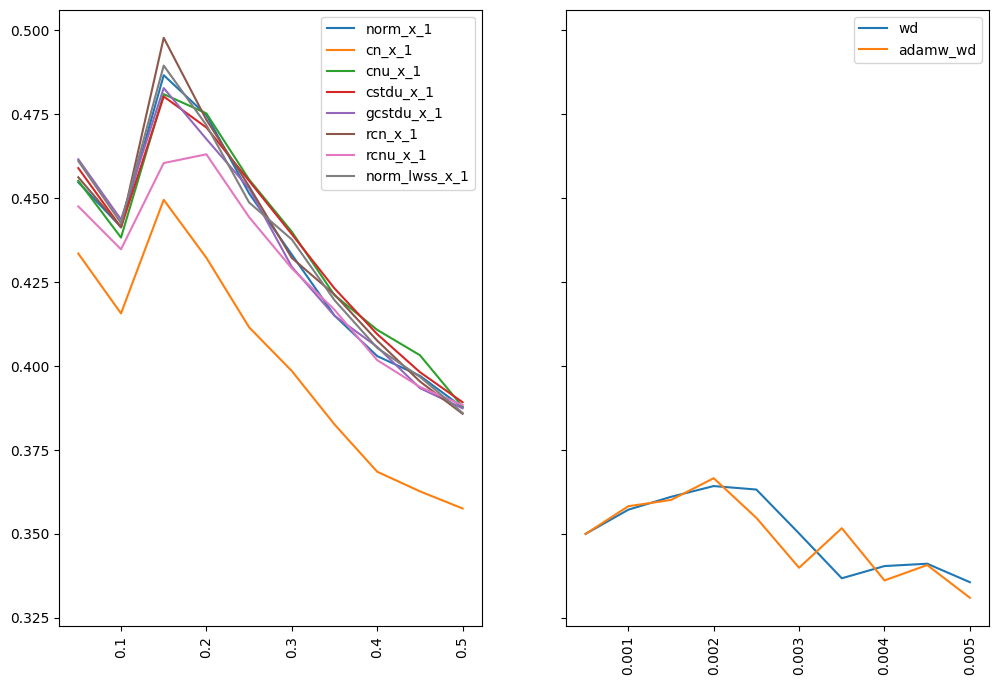

In [3]:
stats = "test_stats"

fig,axs = plt.subplots(ncols=2,sharey="all")
fig.set_size_inches((12,8))
to_plot = [("./exps_adam/norm",lambda p : p.endswith("1"),lambda x :  float(x.split("_")[0]),"acc","norm_x_1",axs[0]),
            ("./exps_adam/center_norm",lambda p : p.endswith("1"),lambda x :  float(x.split("_")[0]),"acc","cn_x_1",axs[0]),
            ("./exps_adam/center_norm_uncenter",lambda p : p.endswith("1"),lambda x :  float(x.split("_")[0]),"acc","cnu_x_1",axs[0]),
            ("./exps_adam/center_std_uncenter",lambda p : p.endswith("1"),lambda x :  float(x.split("_")[0]),"acc","cstdu_x_1",axs[0]),
            ("./exps_adam/global_center_std_uncenter",lambda p : p.endswith("1"),lambda x :  float(x.split("_")[0]),"acc","gcstdu_x_1",axs[0]),
            ("./exps_adam/reverse_center_normalize",lambda p : p.endswith("1"),lambda x :  float(x.split("_")[0]),"acc","rcn_x_1",axs[0]),
            ("./exps_adam/reverse_center_normalize_uncenter",lambda p : p.endswith("1"),lambda x :  float(x.split("_")[0]),"acc","rcnu_x_1",axs[0]),
            ("./exps_adam/norm_lwss",lambda p : p.endswith("1"),lambda x :  float(x.split("_")[0]),"acc","norm_lwss_x_1",axs[0]),
            ("./exps_adam/wd",lambda p : True,lambda x :  float(x),"acc","wd",axs[1]),
            ("./exps_adam/adamw_wd",lambda p : True,lambda x :  float(x),"acc","adamw_wd",axs[1])]

for path,p_fn,to_x_fn,stat,name,ax in to_plot:
    hyperparams = []
    for p in os.listdir(path):
        if not os.path.exists(os.path.join(path,p,"test_stats")):
            continue
        if p_fn(p):
            hyperparams.append(p)
    hyperparams.sort(key=to_x_fn)
    plot_xhyperparams_yacc([os.path.join(path,p,stats)+"/" for p in hyperparams],[to_x_fn(p) for p in hyperparams],stat,name,ax)
    ax.legend()
    ax.tick_params(axis='x', labelrotation=90)


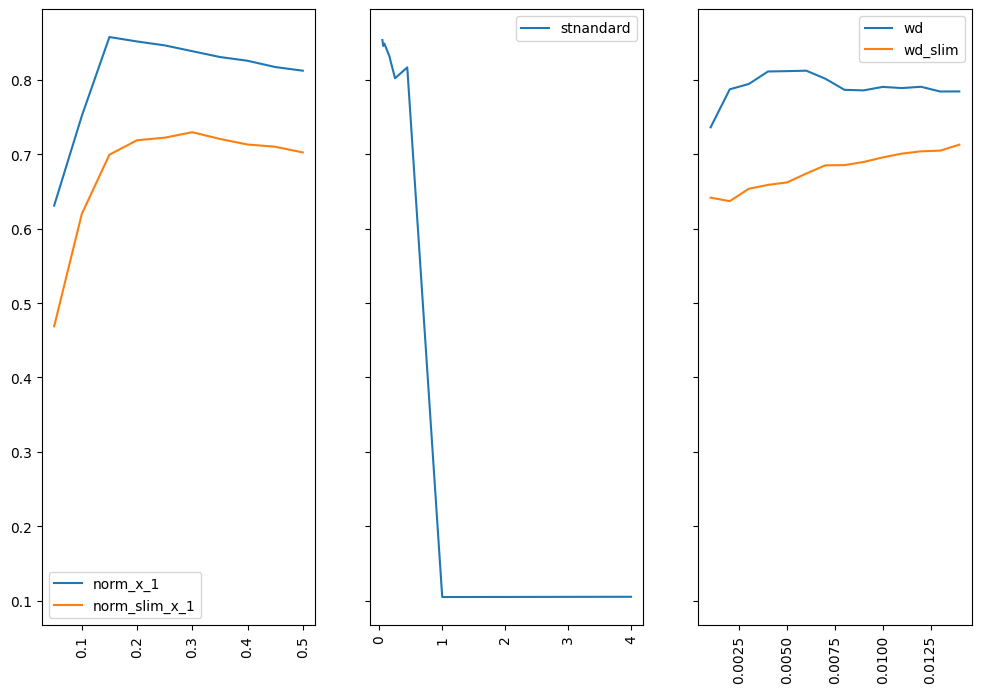

In [ ]:
stats = "test_stats"

fig,axs = plt.subplots(ncols=3,sharey="all")
fig.set_size_inches((12,8))
to_plot = [("./exps_sgdm/norm",lambda p : p.endswith("1"),lambda x :  float(x.split("_")[0]),"acc","norm_x_1",axs[0]),
            ("./exps_sgdm/norm_slim",lambda p : p.endswith("1"),lambda x :  float(x.split("_")[0]),"acc","norm_slim_x_1",axs[0]),
            ("./exps_sgdm/standard",lambda p : True,lambda x :  float(x),"acc","standard",axs[1]),
            ("./exps_sgdm/wd",lambda p : True,lambda x :  float(x),"acc","wd",axs[2]),
            ("./exps_sgdm/wd_slim",lambda p : True,lambda x :  float(x),"acc","wd_slim",axs[2])]

for path,p_fn,to_x_fn,stat,name,ax in to_plot:
    hyperparams = []
    for p in os.listdir(path):
        if not os.path.exists(os.path.join(path,p,"test_stats")):
            continue
        if p_fn(p):
            hyperparams.append(p)
    hyperparams.sort(key=to_x_fn)
    plot_xhyperparams_yacc([os.path.join(path,p,stats)+"/" for p in hyperparams],[to_x_fn(p) for p in hyperparams],stat,name,ax)
    ax.legend()
    ax.tick_params(axis='x', labelrotation=90)
